You can follow along and play with this notebook by clicking the badge below

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jasongfleischer/UCSD_COGS118A/blob/main/demo_notebooks/lecture_16_support_vector_machines.ipynb)

# Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

Let's make a classification task, in which the two classes of points are well separated:

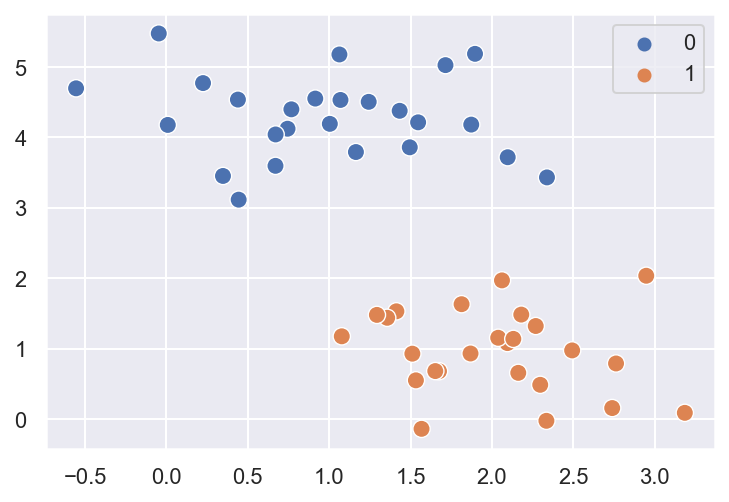

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);


A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

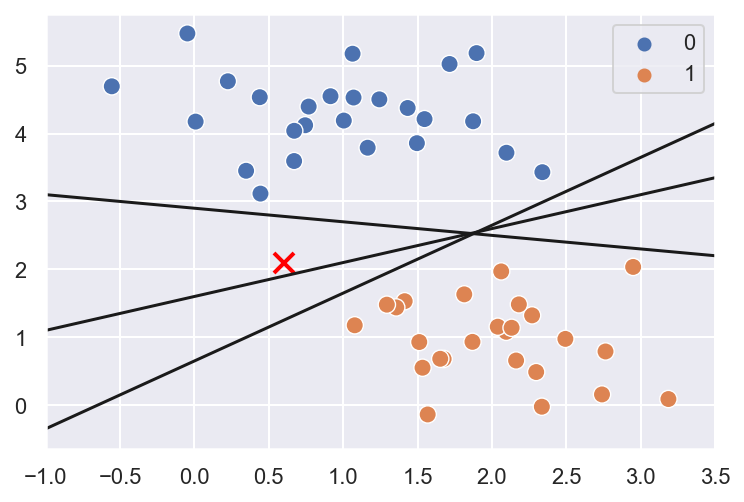

In [6]:
xfit = np.linspace(-1, 3.5)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);


plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

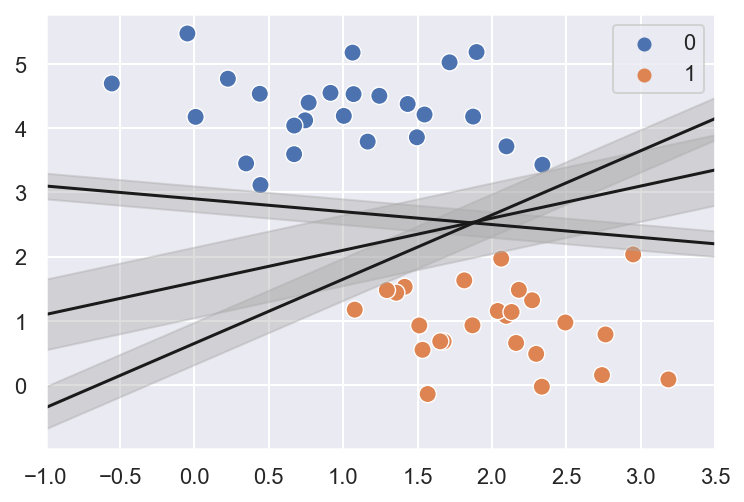

In [7]:
xfit = np.linspace(-1, 3.5)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [8]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [25]:
dir(model)

['C',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_check_proba',
 '_compute_kernel',
 '_decision_function',
 '_dense_decision_function',
 '_dense_fit',
 '_dense_predict',
 '_dense_predict_proba',
 '_dual_coef_',
 '_estimator_type',
 '_gamma',
 '_get_coef',
 '_get_param_names',
 '_get_tags',
 '_impl',
 '_intercept_',
 '_more_tags',
 '_n_support',
 '_pairwise',
 '_predict_log_proba',
 '_predict_proba',
 '_probA',
 '_probB',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sparse',
 '_sparse_decision_function',
 '_sparse_fit',
 '_sparse_kernels',
 '_sparse_predi

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [9]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=3, facecolors='none', edgecolor='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

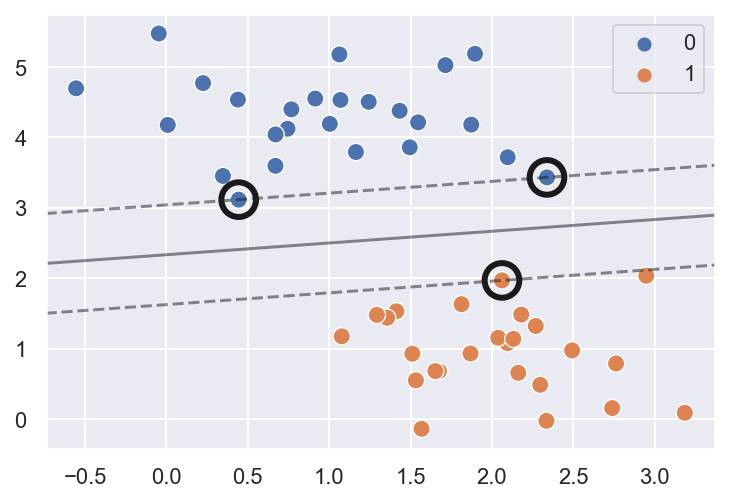

In [10]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);

plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [11]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

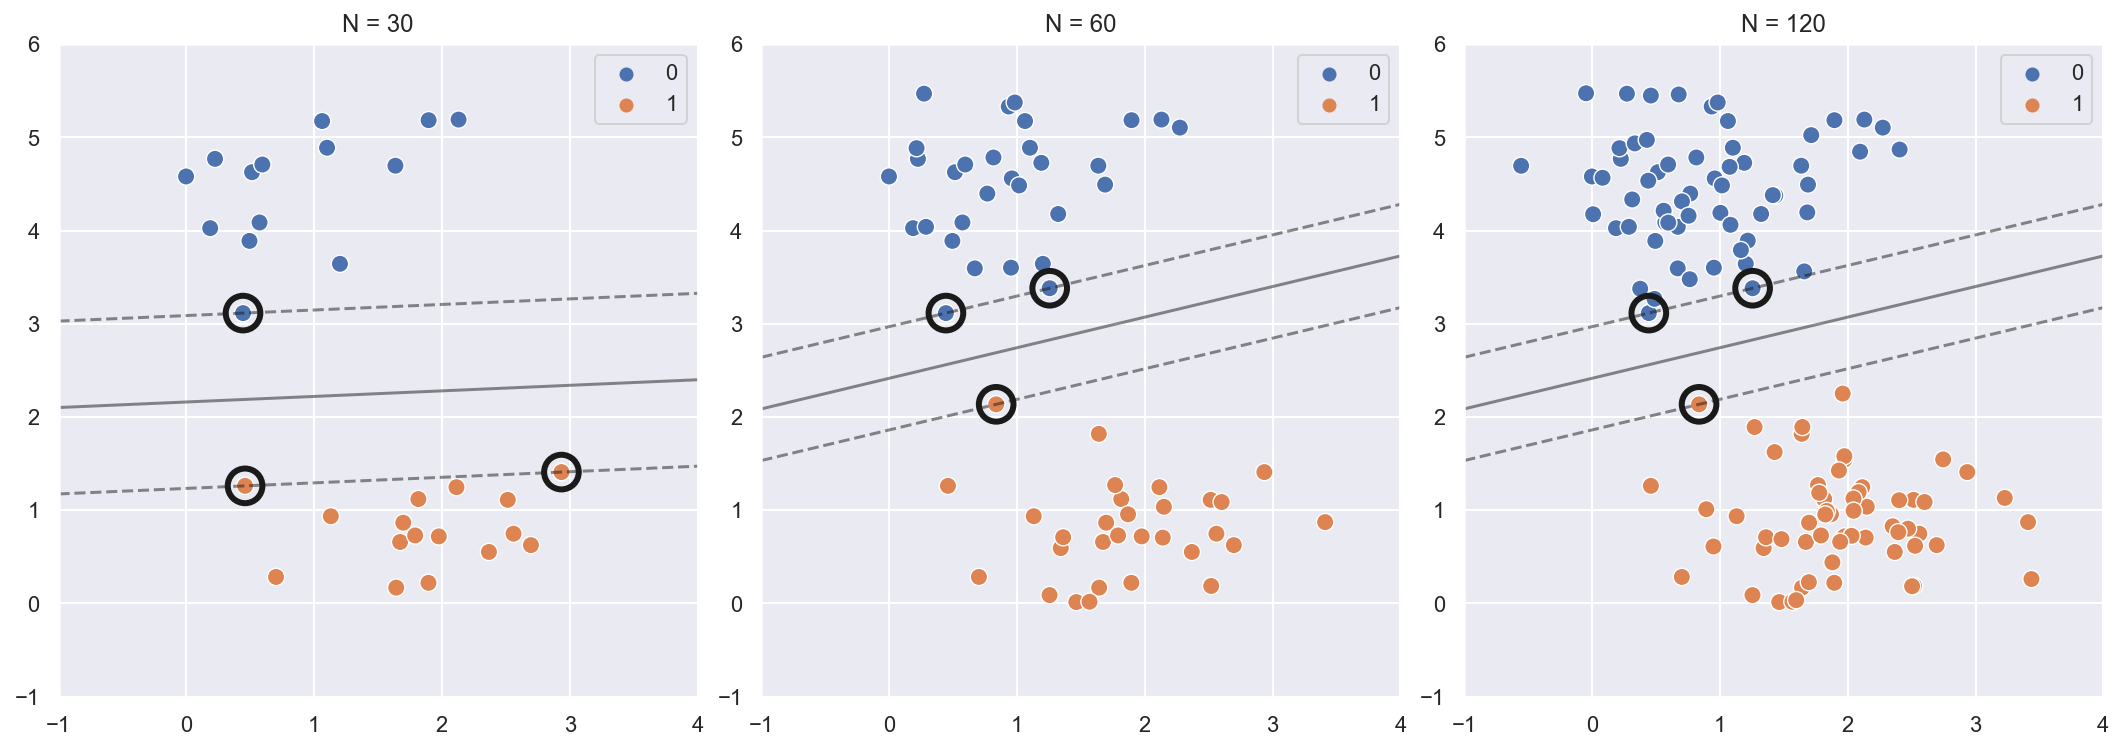

In [13]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75, ax=ax)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [30, 60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for just 10 training points, in the middle we see  60 training points and on the right panel 120 points.  While going from 30 to 60 caused changes, going from 60 to 120 did not becuase the support vectors (the points on the margin line) had not changed.

This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before: Remember polynomial features from the regression lectures?  

There we projected our data into higher-dimensional space defined by polynomials functions, and thereby were able to fit for nonlinear relationships with a linear regression.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

<IPython.core.display.Javascript object>


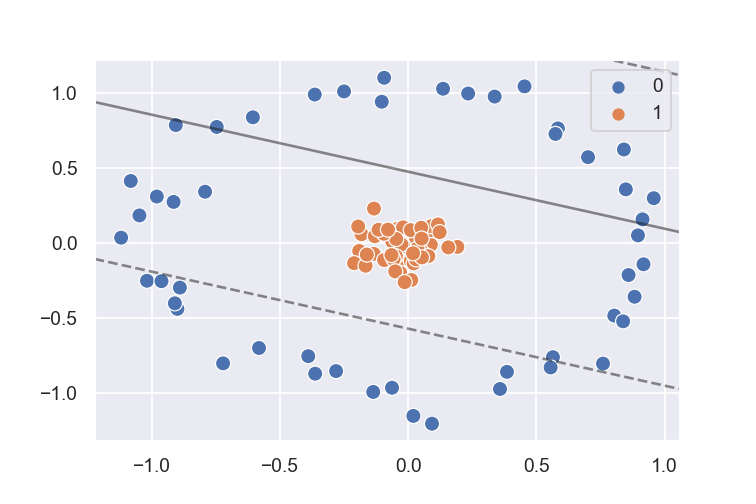

In [29]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75)
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.

One simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [30]:
r = np.exp(-(X ** 2).sum(1))

Adding r as a 3rd dimension gives us this:

<IPython.core.display.Javascript object>


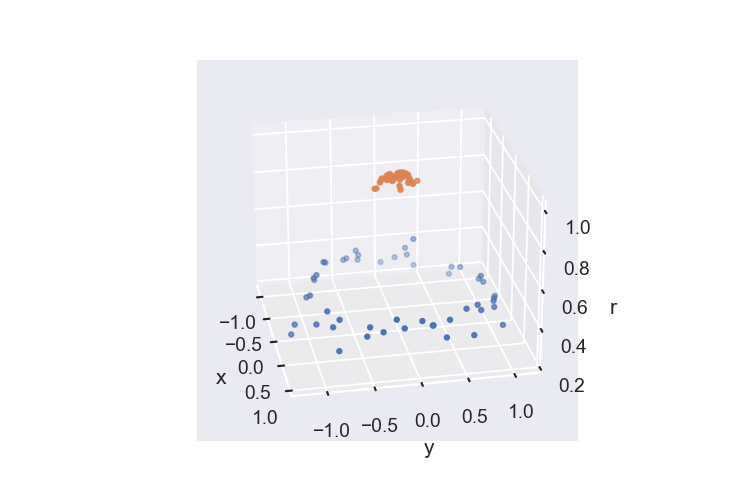

In [31]:
%matplotlib notebook

from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette()[:2])

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=7, cmap=cmap)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');


We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [18]:
%matplotlib inline

In [19]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

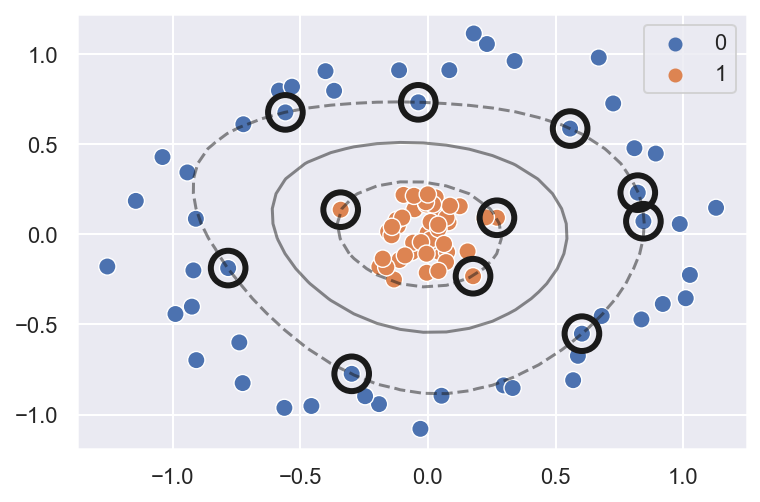

In [20]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none', edgecolor='k');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

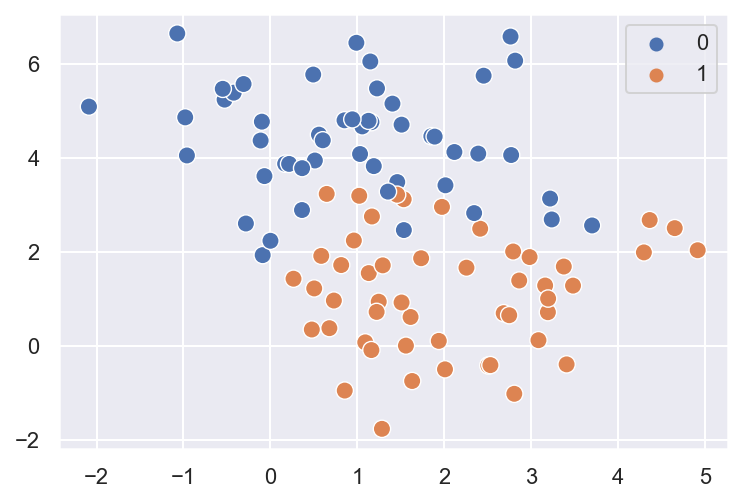

In [21]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75);

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

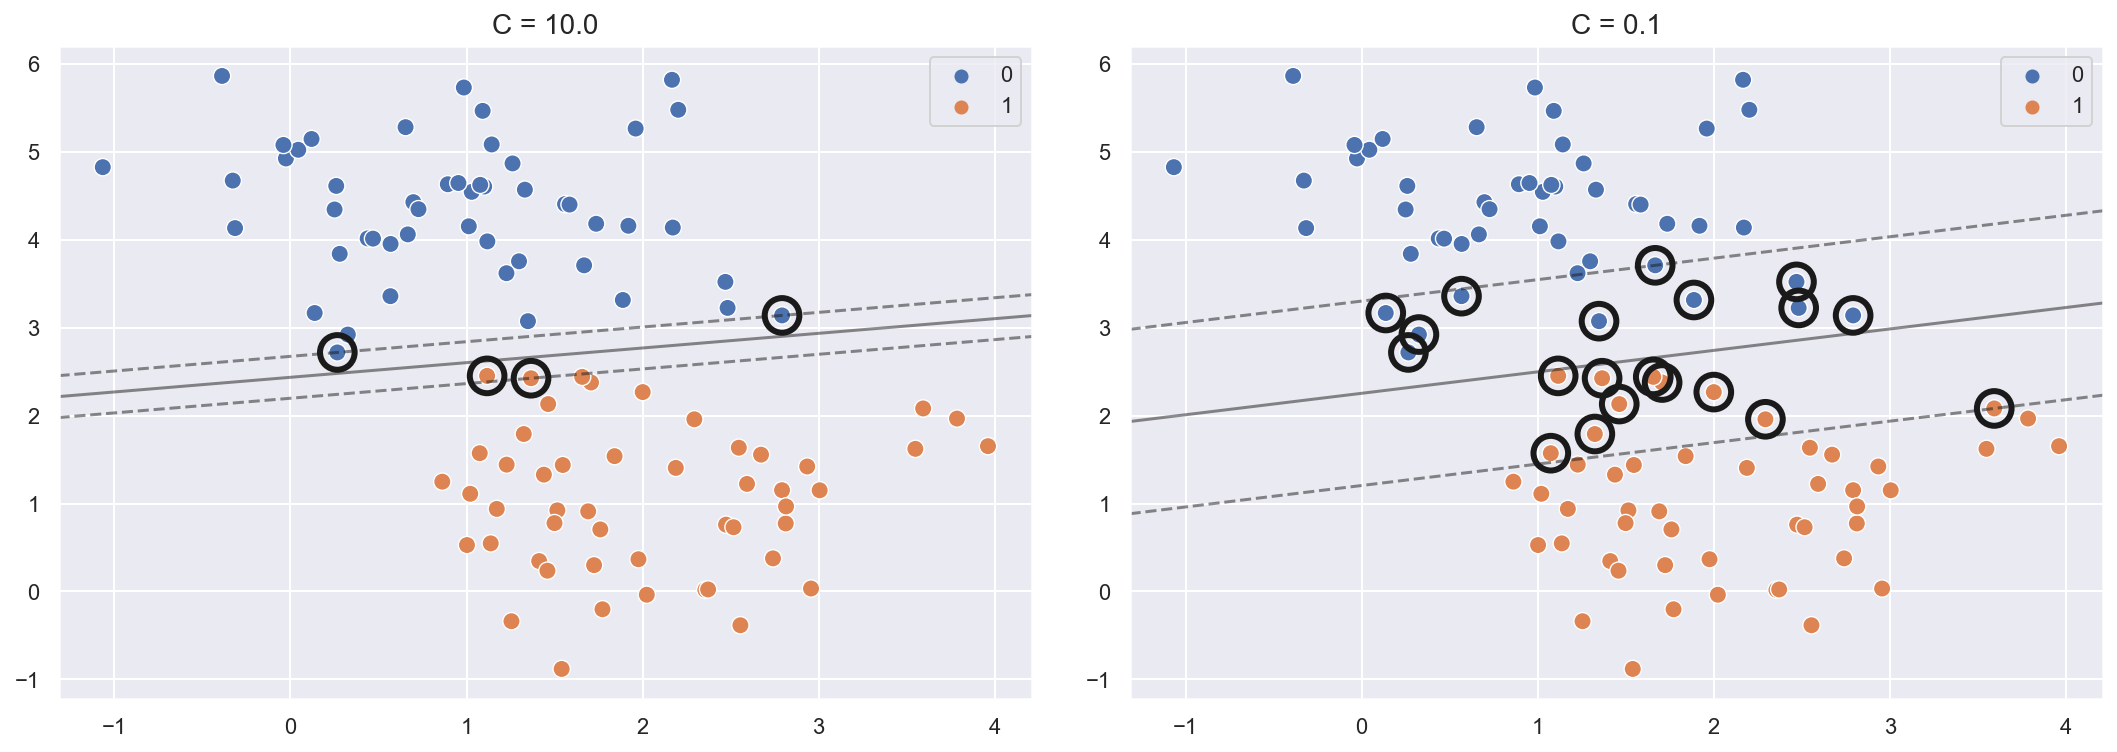

In [22]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=75, ax=axi)
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none', edgecolor='k');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar model selection procedure.

## Example: 

In [9]:
# NOTE: this will take around 2-3 minutes to run

import numpy as np

import seaborn as sns

import pandas as pd 

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

# lets get some 🐧 data to work with
df = sns.load_dataset('penguins').dropna()

# what we want to predict
y = df['species']
X = df.drop(columns=['island','species'])

# setup a way to transform the categorical variables into one hot, 
# and to z-score the numeric variables
# remember how we had to do this with a bunch of different
# steps manually the last time around??
# if you'd like to understand how to do this more generally
# search the sklearn docs for ColumnTransformer!
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

onehot = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('onehot', onehot, categorical_columns),
    ('zscore', scaler, numerical_columns)])


# Create a pipeline 
pipe = Pipeline([('make_features', preprocessor),
                 ('classifier', SVC())])

# SVM have very different hyperparameters depending on which kernel
# potential hyperparams are gamma, coef0, degree and kernel.
# linear kernel:     <x,x'>  [no hyperparams]
# poly kernel:       ( gamma * <x,x'> + coef0 )^degree 
# rbf kernel:        exp( - gamma * ||x-x'||^2 )
# sigmoid kernel:    tanh( gamma * <x,x'> + coef0 )

# so how can we search all the hypers, only using hypers appropriate for each kernel?
# like this...make a list of different search spaces you want to execute
search_space = [{'classifier__kernel': ['linear'],
                 'classifier__C': np.logspace(-3, 2, 11) #11 steps between 10^-3 to 10^2
                },
                {'classifier__kernel': ['poly'],
                 'classifier__gamma': np.logspace(-3, 2, 11),
                 'classifier__degree': range(2,14),
                 # NOPE... this isnt often important 'classifier__coef0': np.logspace(-3, 2, 11),
                 'classifier__C': np.logspace(-3, 2, 11)
                },
                {'classifier__kernel': ['rbf'],
                 'classifier__gamma': np.logspace(-3, 2, 11),
                 'classifier__C': np.logspace(-3, 2, 11)
                },
                ]



# Create a grid search object to find the best model
best_model = GridSearchCV(pipe, search_space, cv=5, verbose=1)
# play with different verbose=??

# now lets split off some of our data for testing set... the rest will be used from cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=101)


# Fit grid search
best_model.fit(X_train, y_train)




Fitting 5 folds for each of 1584 candidates, totalling 7920 fits
[CV] END .....classifier__C=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END .....classifier__C=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END .....classifier__C=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END .....classifier__C=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END .....classifier__C=0.001, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__kernel=linear; total time=   0.0s
[CV] END ......classifier__C=0.01, classifier__kernel=linear; total ti

[CV] END classifier__C=0.001, classifier__degree=2, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=2, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=2, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=2, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=2, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=2, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=2, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=2, classifier__gamma=100.0, classifier_

[CV] END classifier__C=0.001, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=4, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=4, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=4, classifier__gamma=0.1, classifier__

[CV] END classifier__C=0.001, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=5, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=5, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=5, classifier__gamma=1.0, classifier__

[CV] END classifier__C=0.001, classifier__degree=6, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=6, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=6, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=6, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=6, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=6, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=6, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=6, classifier__gamma=31.622776601683793, classifier__ke

[CV] END classifier__C=0.001, classifier__degree=8, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=8, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=8, classifier__gamma=0.01

[CV] END classifier__C=0.001, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=9, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=9, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=9, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=9, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=9, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s


[CV] END classifier__C=0.001, classifier__degree=10, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=10, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=10, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=10, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=10, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=10, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=10, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=10, classifier__gamma=3.1622776601683795, classifie

[CV] END classifier__C=0.001, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; tota

[CV] END classifier__C=0.001, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=13, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=13, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.001, classifier__degree=13, classifier__gam

[CV] END classifier__C=0.0031622776601683794, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=2, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=

[CV] END classifier__C=0.0031622776601683794, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   

[CV] END classifier__C=0.0031622776601683794, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=4, classifier__gamma=100.0, classifier__kernel=po

[CV] END classifier__C=0.0031622776601683794, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=po

[CV] END classifier__C=0.0031622776601683794, classifier__degree=7, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=7, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=7, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total t

[CV] END classifier__C=0.0031622776601683794, classifier__degree=8, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=

[CV] END classifier__C=0.0031622776601683794, classifier__degree=9, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=9, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=9, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=9, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=

[CV] END classifier__C=0.0031622776601683794, classifier__degree=10, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=10, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=10, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   

[CV] END classifier__C=0.0031622776601683794, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=12, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=12, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.003162277

[CV] END classifier__C=0.0031622776601683794, classifier__degree=13, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__degree=13, classifier__gamma=0.01,

[CV] END classifier__C=0.01, classifier__degree=2, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=2, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=2, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=2, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=2, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=2, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=2, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=2, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END

[CV] END classifier__C=0.01, classifier__degree=3, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=3, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=3, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=3, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=3, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=3, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=3, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=3, classifier__gamma=31.622776601683793, classifier__kernel=pol

[CV] END classifier__C=0.01, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=5, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=5, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=5, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=

[CV] END classifier__C=0.01, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=6, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=6, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=6, classifier__gamma=0.1, classifier__kernel=p

[CV] END classifier__C=0.01, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=

[CV] END classifier__C=0.01, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=8, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=8, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=8, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=8, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=

[CV] END classifier__C=0.01, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=10, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=10, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=10, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=10, classifier__gamma=0.0031622776601683794, classifier__

[CV] END classifier__C=0.01, classifier__degree=11, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=11, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=11, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=11, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=11, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=11, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=11, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=11, classifier__gamma=0.1, classifier_

[CV] END classifier__C=0.01, classifier__degree=12, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=12, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=12, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=12, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=12, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=12, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=12, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=12, classifier__gamma=1.0, classifier__

[CV] END classifier__C=0.01, classifier__degree=13, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=13, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=13, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=13, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=13, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=13, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=13, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.01, classifier__degree=13, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0

[CV] END classifier__C=0.03162277660168379, classifier__degree=2, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=2, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=3, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=3, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=3, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=3, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=3, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier_

[CV] END classifier__C=0.03162277660168379, classifier__degree=4, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=4, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=4, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=4, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[C

[CV] END classifier__C=0.03162277660168379, classifier__degree=5, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=5, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=5, classifier__gamma=1.0, classifier__kernel=poly; total ti

[CV] END classifier__C=0.03162277660168379, classifier__degree=6, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=6, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=6, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=6, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=6, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=6, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=6, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.031622776

[CV] END classifier__C=0.03162277660168379, classifier__degree=7, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=8, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=8, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=8, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=8, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=8, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168

[CV] END classifier__C=0.03162277660168379, classifier__degree=9, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=9, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=9, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=9, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=9, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0316227

[CV] END classifier__C=0.03162277660168379, classifier__degree=10, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=10, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=10, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=10, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=10, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=10, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=10, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0

[CV] END classifier__C=0.03162277660168379, classifier__degree=11, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=11, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=11, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=11, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=11, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=11, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=11, classifier__gamma=10.0, classifier__kernel=poly; tota

[CV] END classifier__C=0.03162277660168379, classifier__degree=12, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=12, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=12, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=12, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=12, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=12, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__degree=13, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.0316227766

[CV] END classifier__C=0.1, classifier__degree=2, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=2, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=2, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=2, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=2, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=2, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END 

[CV] END classifier__C=0.1, classifier__degree=3, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=3, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=3, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=3, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=3, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=3, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=3, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=3, classifier__gamma=0.31622776601683794, classifier__kernel=poly; tot

[CV] END classifier__C=0.1, classifier__degree=4, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=4, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END class

[CV] END classifier__C=0.1, classifier__degree=5, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classif

[CV] END classifier__C=0.1, classifier__degree=7, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; to

[CV] END classifier__C=0.1, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=8, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifi

[CV] END classifier__C=0.1, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=9, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=9, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=9, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=9, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=9, classifier__gamma=31.622776601683793, classifier__kernel=poly; total

[CV] END classifier__C=0.1, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=11, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=11, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END

[CV] END classifier__C=0.1, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kerne

[CV] END classifier__C=0.1, classifier__degree=13, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=13, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.1, classifier__degree=13, classifier__gamma=1.0, classifier__kernel=p

[CV] END classifier__C=0.31622776601683794, classifier__degree=2, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=2, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=2, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=2, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=2, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=2, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=2, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.316227766

[CV] END classifier__C=0.31622776601683794, classifier__degree=3, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=3, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=3, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=3, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=3, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=3, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=3, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.3162

[CV] END classifier__C=0.31622776601683794, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=5, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=5, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=5, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=5, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=5, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=5, classifier__gamma=0.01, classifier__kernel=p

[CV] END classifier__C=0.31622776601683794, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=6, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=6, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=6, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=6, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] 

[CV] END classifier__C=0.31622776601683794, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=7, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=7, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683

[CV] END classifier__C=0.31622776601683794, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=8, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=8, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.316227766

[CV] END classifier__C=0.31622776601683794, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=10, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=10, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=10, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classif

[CV] END classifier__C=0.31622776601683794, classifier__degree=11, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=11, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=11, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=11, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=11, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=11, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=11, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END class

[CV] END classifier__C=0.31622776601683794, classifier__degree=12, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=12, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total 

[CV] END classifier__C=0.31622776601683794, classifier__degree=13, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=2, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=2, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=2, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=2, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=2, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=2, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=2, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s

[CV] END classifier__C=1.0, classifier__degree=3, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=3, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=3, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=3, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=3, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=3, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=3, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=3, classifier__gamma=0.1, classifier__kernel=poly; t

[CV] END classifier__C=1.0, classifier__degree=4, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=4, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=4, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END class

[CV] END classifier__C=1.0, classifier__degree=5, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=5, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=5, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=5, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=5, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=5, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classif

[CV] END classifier__C=1.0, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=7, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=7, classifier__gamma=1.0, classifier__kernel=poly; tot

[CV] END classifier__C=1.0, classifier__degree=8, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=8, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=8, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=8, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=8, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=8, classifier__gamma=10.0, classifier__kernel=poly; total

[CV] END classifier__C=1.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=10, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=10, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=10, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV

[CV] END classifier__C=1.0, classifier__degree=11, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=11, classifier__gamma=100.0, classifier__kernel=p

[CV] END classifier__C=1.0, classifier__degree=13, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=13, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=1.0, classifier__degree=13, classifier__gamma=0.01, classi

[CV] END classifier__C=3.1622776601683795, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.162

[CV] END classifier__C=3.1622776601683795, classifier__degree=3, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, cl

[CV] END classifier__C=3.1622776601683795, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=4, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0

[CV] END classifier__C=3.1622776601683795, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.16227

[CV] END classifier__C=3.1622776601683795, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, c

[CV] END classifier__C=3.1622776601683795, classifier__degree=8, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0

[CV] END classifier__C=3.1622776601683795, classifier__degree=9, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=9, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795

[CV] END classifier__C=3.1622776601683795, classifier__degree=10, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=10, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622

[CV] END classifier__C=3.1622776601683795, classifier__degree=12, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=12, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=12, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END cl

[CV] END classifier__C=3.1622776601683795, classifier__degree=13, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=13, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=13, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=13, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=13, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=13, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__degree=13, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifi

[CV] END classifier__C=10.0, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=2, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END

[CV] END classifier__C=10.0, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=3, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=3, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=3, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=3, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=3, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] E

[CV] END classifier__C=10.0, classifier__degree=4, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=4, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=4, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=4, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=5, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier_

[CV] END classifier__C=10.0, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=6, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=6, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=6, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=6, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=6, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.

[CV] END classifier__C=10.0, classifier__degree=7, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=7, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=7, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=7, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=7, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=7, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=7, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=7, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] E

[CV] END classifier__C=10.0, classifier__degree=8, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=8, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=8, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=9, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=9, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=9, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=9, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=9, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier_

[CV] END classifier__C=10.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=10, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=10, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=10, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=10, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   

[CV] END classifier__C=10.0, classifier__degree=11, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=11, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=11, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=11, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=11, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=11, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=11, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=11, classifier__gamma=1.0, classifier__

[CV] END classifier__C=10.0, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=12, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=12, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=12, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=12, classifier__gamma=10.0, classifier__ke

[CV] END classifier__C=10.0, classifier__degree=13, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=13, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=13, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=13, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=13, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=13, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=13, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=10.0, classifier__degree=13, classifier__gamma=100.0, classifier__kernel=poly; total time= 

[CV] END classifier__C=31.622776601683793, classifier__degree=3, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=3, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=3, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=3, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=3, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=3, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=3, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601

[CV] END classifier__C=31.622776601683793, classifier__degree=4, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=4, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=4, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=4, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=4, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=4, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=4, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0

[CV] END classifier__C=31.622776601683793, classifier__degree=5, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=5, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=5, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=5, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=5, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=5, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=5, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END clas

[CV] END classifier__C=31.622776601683793, classifier__degree=6, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=6, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=6, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=6, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=6, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=7, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=7, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=

[CV] END classifier__C=31.622776601683793, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=8, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=8, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=8, classifier__gamma=0.01, classifier__kernel=poly; tot

[CV] END classifier__C=31.622776601683793, classifier__degree=9, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=9, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=9, classifier__gamma=0.1, classifier__kernel=poly; total time=   

[CV] END classifier__C=31.622776601683793, classifier__degree=10, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=10, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=10, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=10, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=10, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=10, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=10, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683

[CV] END classifier__C=31.622776601683793, classifier__degree=11, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=11, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=11, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=

[CV] END classifier__C=31.622776601683793, classifier__degree=13, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=13, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=13, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__degree=13, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time

[CV] END classifier__C=100.0, classifier__degree=2, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=2, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=2, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=2, classifier__gamma=0.1, classifier_

[CV] END classifier__C=100.0, classifier__degree=3, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=3, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=3, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=3, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[

[CV] END classifier__C=100.0, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=4, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=4, classifier__gamma=31.622776601683793, classifier__ke

[CV] END classifier__C=100.0, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=6, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=6, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=6, classifier__gamma=0.0

[CV] END classifier__C=100.0, classifier__degree=7, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=7, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=7, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=7, classifier__gamma=0.1, classifier_

[CV] END classifier__C=100.0, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=8, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=8, classifier__gamma=1.0, classifier__kernel=poly; tot

[CV] END classifier__C=100.0, classifier__degree=9, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=9, classifier__gamma=3.1622776601683795, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=9, classifier__gamma=10.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=9, classifier__gamma=31.622776601683793, classifier__kernel=poly; total time=   0.0

[CV] END classifier__C=100.0, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=10, classifier__gamma=100.0, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=11, classifier__gamma=0.001, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=11, classifier__gamma=0.0031622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END

[CV] END classifier__C=100.0, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=12, classifier__gamma=0.01, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=12, classifier__gamma=0.03162277660168379, classifier__kern

[CV] END classifier__C=100.0, classifier__degree=13, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=13, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=13, classifier__gamma=0.1, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=13, classifier__gamma=0.31622776601683794, classifier__kernel=poly; total time=   0.0s
[CV] END classifier__C=100.0, classifier__degree=13, classifier__gamma=0.31622776601683794, clas

[CV] END classifier__C=0.001, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.001, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.0031622776601683794, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.0031622776601

[CV] END classifier__C=0.01, classifier__gamma=0.03162277660168379, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.03162277660168379, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.03162277660168379, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.31622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__gamma=0.31622776601683794, classifier__k

[CV] END classifier__C=0.03162277660168379, classifier__gamma=10.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__gamma=10.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__gamma=10.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__gamma=10.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__gamma=10.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__gamma=31.622776601683793, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__gamma=31.622776601683793, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__gamma=31.622776601683793, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.03162277660168379, classifier__gamma=31.62277

[CV] END classifier__C=0.31622776601683794, classifier__gamma=0.31622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__gamma=0.31622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__gamma=0.31622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__gamma=0.31622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__gamma=0.31622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__gamma=1.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__gamma=1.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.31622776601683794, classifier__gamma=1.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.316227766016837

[CV] END classifier__C=3.1622776601683795, classifier__gamma=0.0031622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__gamma=0.0031622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__gamma=0.0031622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__gamma=0.0031622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__gamma=0.0031622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__gamma=0.01, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__gamma=0.01, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=3.1622776601683795, classifier__gamma=0.01, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=3.1622776601

[CV] END classifier__C=10.0, classifier__gamma=0.31622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=0.31622776601683794, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=1.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=1.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=1.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=1.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=1.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=3.1622776601683795, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=3.1622776601683795, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=10.0, classifier__gamma=3.1622776601683795, classifier__kern

[CV] END classifier__C=31.622776601683793, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=31.622776601683793, classifier__gamma=100.0, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100.0, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100.0, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100.0, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100.0, classifier__gamma=0.001, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=100.0, classifier__gamma=0.001

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('make_features',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['sex']),
                                                                        ('zscore',
                                                                         StandardScaler(),
                                                                         ['bill_length_mm',
                                                                          'bill_depth_mm',
                                                                          'flipper_length_mm',
                                                                          'body_mass_g'])])),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.0...
                         {'classifier__C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02]),
                          'classifier__gamma': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02]),
                          'classifier__kernel': ['rbf']}],
             verbose=2)

{'classifier__C': 12.32846739442066, 'classifier__kernel': 'linear'}
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.99        36
   Chinstrap       0.96      1.00      0.98        23
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



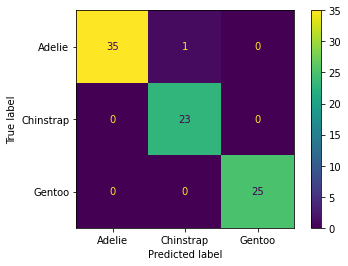

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# lets find out how well we do on the test set...
print(best_model.best_params_)
yhat = best_model.predict(X_test)
print(classification_report(y_test, yhat))
ConfusionMatrixDisplay.from_predictions(y_test, yhat);

In [1]:
# Lets run EXACTLY the same grid search as before, but this time
# lets use a different kind of dataset, a tougher problem, so 
# maybe the best classifier wont be the simple linear hard classifier as
# with penguins

import numpy as np

import seaborn as sns

import pandas as pd 

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.datasets import load_breast_cancer

# lets try some very differen data
# these are measurements of various tumors... the job is to 
# classifiy the tumor as malignant or benign
# data from https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
cdata = load_breast_cancer(as_frame=True)
X = cdata['data']
y = cdata['target']

# setup a way to transform the categorical variables into one hot, 
# and to z-score the numeric variables
# remember how we had to do this with a bunch of different
# steps manually the last time around??
# if you'd like to understand how to do this more generally
# search the sklearn docs for ColumnTransformer!
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

onehot = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('onehot', onehot, categorical_columns),
    ('zscore', scaler, numerical_columns)])


# Create a pipeline 
# NOTE: without the max_iter argument my computer was starting 
# to melt after 20 min... this data is so much harder to deal with
# and especially high C - hard margin SVM are still NOT CONVERGING after
# very long periods of time
# you can see the problem in the thousands of convergence warnings below
# once the max_iter is reached
pipe = Pipeline([('make_features', preprocessor),
                 ('classifier', SVC(max_iter=5000))])

# SVM have very different hyperparameters depending on which kernel
# potential hyperparams are gamma, coef0, degree and kernel.
# linear kernel:     <x,x'>  [no hyperparams]
# poly kernel:       ( gamma * <x,x'> + coef0 )^degree 
# rbf kernel:        exp( - gamma * ||x-x'||^2 )
# sigmoid kernel:    tanh( gamma * <x,x'> + coef0 )

# so how can we search all the hypers, only using hypers appropriate for each kernel?
# like this...make a list of different search spaces you want to execute
search_space = [{'classifier__kernel': ['linear'],
                 'classifier__C': np.logspace(-3, 2, 11) #11 steps between 10^-3 to 10^2
                },
                {'classifier__kernel': ['poly'],
                 'classifier__gamma': np.logspace(-3, 2, 11),
                 'classifier__degree': range(2,14),
                 # NOPE... this isnt often important 'classifier__coef0': np.logspace(-3, 2, 11),
                 'classifier__C': np.logspace(-3, 2, 11)
                },
                {'classifier__kernel': ['rbf'],
                 'classifier__gamma': np.logspace(-3, 2, 11),
                 'classifier__C': np.logspace(-3, 2, 11)
                },
                ]



# Create a grid search object to find the best model
best_model = GridSearchCV(pipe, search_space, cv=5, verbose=1)
# play with different verbose=??

# now lets split off some of our data for testing set... the rest will be used from cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=101)


# Fit grid search
best_model.fit(X_train, y_train)





Fitting 5 folds for each of 1584 candidates, totalling 7920 fits


/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jasonfleischer/opt/anaconda3/envs/py39_DSML_base/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardS

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('make_features',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         []),
                                                                        ('zscore',
                                                                         StandardScaler(),
                                                                         ['mean '
                                                                          'radius',
                                                                          'mean '
                                                                          'texture',
                                                                          'mean '
                                                                          'perimeter',
                                                                          'mean '
                                                                          'area',
                                                                          'mean '
                                                                          'smoothness',
                                                                          'mean '
                                                                          'compactness',
                                                                          'mean '
                                                                          'concavity',
                                                                          'mean '
                                                                          'concave '
                                                                          'points',
                                                                          'mean '
                                                                          'symmetry',
                                                                          'mean '
                                                                          'fractal '
                                                                          'dimension',
                                                                          'radius '
                                                                          'err...
                         {'classifier__C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02]),
                          'classifier__gamma': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02]),
                          'classifier__kernel': ['rbf']}],
             verbose=1)

{'classifier__C': 10.0, 'classifier__gamma': 0.03162277660168379, 'classifier__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        55
           1       0.99      0.99      0.99        88

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



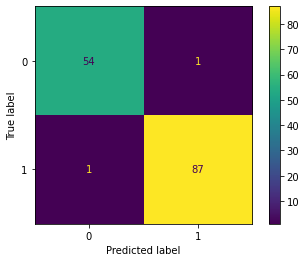

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# lets find out how well we do on the test set...
print(best_model.best_params_)
yhat = best_model.predict(X_test)
print(classification_report(y_test, yhat))
ConfusionMatrixDisplay.from_predictions(y_test, yhat);

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.


*This notebook contains excerpts of text and code from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook). The text from the book was released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code from the book is released under the [MIT license](https://opensource.org/licenses/MIT).* 

*This notebook also contains text and code written by Jason Fleischer.  I'm too tired to think much about it, so I'm happy to release my work under the same licenses*